#### 1. Imports

In [1]:
import os
import json
from typing import Annotated, Sequence, TypedDict

from langchain_core.messages import (
    HumanMessage, AIMessage, BaseMessage, ToolMessage
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from langchain_tavily import TavilySearch
from langchain.tools import tool

from toolbox_langchain import ToolboxClient

from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages

#### 2. Async Load MCP Tools

In [2]:
mcp_client = ToolboxClient("http://127.0.0.1:5000")

async def load_mcp():
    return await mcp_client.aload_toolset()

mcp_tools = await load_mcp()
print("Loaded MCP tools:", [t.name for t in mcp_tools])

Loaded MCP tools: ['average-price-by-flat-type', 'count-hdb-flats-by-town', 'execute-sql-tool', 'list-hdb-flats-by-town', 'percentile-price-by-town', 'postgres-list-tables']


#### 3. Tavily + Amenities Tool

In [3]:
tavily = TavilySearch(max_results=5)

@tool
def search_hdb_amenities(query: str) -> str:
    """
    Search for amenities near an HDB block or town using Tavily.

    Example queries:
    - "amenities near Block 123 Ang Mo Kio"
    - "schools near Bukit Panjang"
    - "supermarkets near Tampines"
    - "parks near Woodlands"

    The tool returns summarized search results.
    """
    formatted_query = f"amenities around {query}, Singapore HDB, nearby facilities, schools, supermarkets, malls, transport"
    results = tavily.invoke(formatted_query)
    return results

#### 4. Collect all tools

In [4]:
tools = [tavily, search_hdb_amenities] + mcp_tools
tools_by_name = {t.name: t for t in tools}

print("All tools loaded:", list(tools_by_name.keys()))

All tools loaded: ['tavily_search', 'search_hdb_amenities', 'average-price-by-flat-type', 'count-hdb-flats-by-town', 'execute-sql-tool', 'list-hdb-flats-by-town', 'percentile-price-by-town', 'postgres-list-tables']


#### 5. Agent Prompt (ReAct)

In [5]:
chat_prompt = ChatPromptTemplate.from_messages([
    ("system", """
You are an intelligent ReAct-style assistant with access to Postgres SQL (via MCP Toolbox)
and real-world web search tools (Tavily + amenities search).

Use SQL tools for:
- HDB transactions
- resale prices
- median / percentile
- flat type analysis
- town or block queries

Use search_hdb_amenities for:
- schools
- malls
- supermarkets
- parks
- hospitals
- amenities around blocks/towns

Use Tavily for general external knowledge.

Always:
1. Think step-by-step
2. Choose the correct tool
3. Call tools with correct arguments
4. Integrate tool output into your answer
"""),
    MessagesPlaceholder("scratch_pad")
])

#### 6. Bind model and tools

In [6]:
MODEL = "moonshotai/kimi-k2-thinking"

model = ChatOpenAI(
    api_key=os.getenv("OPENROUTER_API_KEY"),
    base_url="https://openrouter.ai/api/v1",
    model=MODEL,
)

# Bind tools for ReAct
model_react = chat_prompt | model.bind_tools(tools)

#### 7. Agent State Definition

In [7]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

#### 8. Define Async Model and Tool nodes

In [8]:
async def call_model(state: AgentState):
    response = await model_react.ainvoke({"scratch_pad": state["messages"]})
    return {"messages": [response]}

async def tool_node(state: AgentState):
    outputs = []
    last = state["messages"][-1]

    for tc in last.tool_calls:
        tool = tools_by_name[tc["name"]]

        # All toolbox_langchain tools support .ainvoke()
        result = await tool.ainvoke(tc["args"])

        outputs.append(
            ToolMessage(
                content=json.dumps(result),
                name=tc["name"],
                tool_call_id=tc["id"]
            )
        )

    return {"messages": outputs}

#### 9. Continue / End Decision Node

In [9]:
def should_continue(state: AgentState):
    last = state["messages"][-1]
    if last.tool_calls:
        return "continue"
    return "end"

#### 10. Build LangGraph (Async Model)

In [10]:
workflow = StateGraph(AgentState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge("tools", "agent")

workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "tools",
        "end": END,
    }
)

workflow.set_entry_point("agent")

graph = workflow.compile()

#### 11. Run the agent (Async Streaming)

##### Test 1 — Resale Transactions

In [11]:
inputs = {
    "messages": [
        HumanMessage("Get me the past resale transactions for block 100 in Toa Payoh.")
    ]
}

async for step in graph.astream(inputs, stream_mode="values"):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Get me the past resale transactions for block 100 in Toa Payoh.
================================== Ai Message ==================================

 I'll help you find the resale transactions for block 100 in Toa Payoh. Let me start by checking the database structure to see what information is available.
Tool Calls:
  postgres-list-tables ( functions.postgres-list-tables:0)
 Call ID:  functions.postgres-list-tables:0
  Args:
    output_format: detailed
================================= Tool Message =================================
Name: postgres-list-tables

"[{\"object_details\":{\"columns\":[{\"column_comment\":null,\"column_default\":null,\"column_name\":\"month\",\"data_type\":\"text\",\"is_not_nullable\":false,\"ordinal_position\":1},{\"column_comment\":null,\"column_default\":null,\"column_name\":\"town\",\"data_type\":\"text\",\"is_not_nullable\":false,\"ordinal_position\":2},{\"column_comment\":nul

##### Test 2 — Amenities Around an HDB Block

In [12]:
inputs = {
    "messages": [
        HumanMessage("What amenities are near Block 110 in Toa Payoh?")
    ]
}

async for step in graph.astream(inputs, stream_mode="values"):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What amenities are near Block 110 in Toa Payoh?
================================== Ai Message ==================================
Tool Calls:
  search_hdb_amenities ( functions.search_hdb_amenities:0)
 Call ID:  functions.search_hdb_amenities:0
  Args:
    query: amenities near Block 110 Toa Payoh
================================= Tool Message =================================
Name: search_hdb_amenities

{"query": "amenities around amenities near Block 110 Toa Payoh, Singapore HDB, nearby facilities, schools, supermarkets, malls, transport", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.singaporeunited.sg/explore-modern-living-in-singapores-iconic-toa-payoh-lorong-1-toa-payoh-condo-near-shopping-centres-and-hdb-hub/", "title": "Explore Modern Living in Singapore's Iconic Toa Payoh", "content": "It is located near several shopping centres and HDB Hub, offering u

#### 12. Display Mermaid Diagram

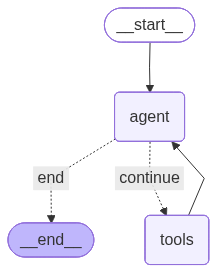

In [13]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))